# Introduction

This notebook demonstrates how to use the [Zenodo dataset](https://doi.org/10.5281/zenodo.1133969) associated with the DeepMoon repo.  Running the notebook requires a subset of the DeepMoon dependencies, as well as the [Matplotlib](https://matplotlib.org/) package.

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import os
from PIL import Image    # Requires Pillow

This is the filepath to the downloaded Zenodo dataset, and needs to be modified to point to your download location:

In [2]:
zenodo_path = './zenodo_downloads/'
deepmoon_path = os.path.dirname(os.getcwd())

# HDF5 Datasets

## Image Datasets

The training, validation and testing DEM images and target masks used to train and evaluate the DeepMoon model are found in `train_images.hdf5`, `dev_images.hdf5` and `test_images.hdf5`, respectively.  Also included in the files are each image's longitude/latitude bounds, and the pixel bounds of the global DEM regions cropped to make each image - these are used to post-process DeepMoon's crater detections.

These data can be read in using `h5py`.  Let's read in the `train_images.hdf5` data:

In [3]:
train_imgs = h5py.File(zenodo_path + '/train_images.hdf5', 'r')

Input images are 256 x 256 8-bit greyscale images, and target masks are 256 x 256 float arrays whose values fall between 0 and 1.  30000 inputs and targets are stored in the HDF5 file as two 30000 x 256 x 256 arrays; inputs can be found under the `'input_images'` entry, and targets under `'target_masks'`.  A target mask represents the ground truth crater locations of the input with the same image number (first array dimension).  Plotting one input-target pair as an example (and setting `vmin` and `vmax` to increase contrast in the input):

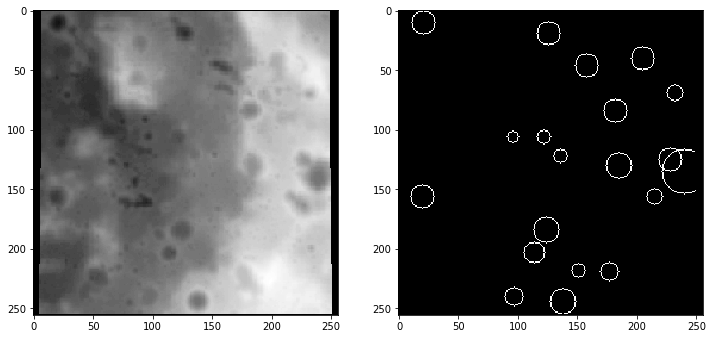

In [4]:
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(train_imgs['input_images'][3][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(train_imgs['target_masks'][3][...], origin='upper', cmap='Greys_r')
plt.show()

The longitude and latitude bounds of the input image can be found under `'longlat_bounds'`.  Here, instead of a 30000-element array, long/lat bounds are indexed by `'img_xxxxx'`, where xxxxx is the (zero-padded) image number, so the 4th image's boundaries are:

In [5]:
train_imgs['longlat_bounds']['img_00003'][...]

array([-177.85546875, -173.87109375,   15.4453125 ,   19.4296875 ])

The definitions of these numbers is under the "definition" attribute for the entry:

In [6]:
train_imgs['longlat_bounds'].attrs['definition']

'(long min, long max, lat min, lat max) of the cropped image.'

Other entries in the HDF5 are to correct for image distortion during post-processing, or are unused in the current pipeline.  Each entry in the HDF5 has definition metadata under its `.attrs['definition']` attribute.

In [7]:
train_imgs['pix_bounds'].attrs['definition']

'Pixel bounds of the Global DEM region that was cropped for the image.'

In [8]:
train_imgs['target_masks'].attrs['definition']

'Target mask dataset.'

## Crater Tables

The ground truth crater data for the images is stored in Pandas HDFStore files `train_craters.hdf5`, `dev_craters.hdf5`, and `test_craters.hdf5` for the training, validation and testing data, respectively.  These tables are used when calculating accuracy metrics for hyperparameter tuning during training.  Let's read in the training ground truth:

In [9]:
ctrs = pd.HDFStore(zenodo_path + '/train_craters.hdf5', 'r')

Like the long/lat boundaries, crater dataframes are indexed by `'img_xxxxx'`, where xxxxx is the zero-padded image number for images from `train_images.hdf5`.  The ground truth for image 3 is:

In [10]:
ctrs['img_00003']

,Diameter (km),Lat,Long,x,y,Diameter (pix)
0,10.550443,15.618482,-175.694082,138.439884,244.900215,22.300142
1,7.530385,15.693656,-176.356974,97.549874,240.048738,15.916739
2,7.943583,16.006064,-175.065360,177.137353,219.965795,16.790103
3,5.332220,16.036702,-175.482448,151.449356,218.081551,11.270547
4,8.098426,16.261849,-176.080687,114.628637,203.667608,17.117390
5,10.709987,16.564495,-175.923507,124.301628,184.276214,22.637364
6,9.185999,16.988845,-177.614291,20.729479,156.583553,19.416160
7,6.599598,16.994128,-174.429989,215.808468,156.407085,13.949364
8,18.446725,17.318118,-174.028395,240.208003,135.428068,38.990266
9,10.084412,17.403728,-174.914875,185.977665,130.334813,21.315106


Here, "Lat", "Long", and "Diameter (km)" are from the combined LROC-Head crater catalog, while "x", "y" and "Diameter (pix)" were derived from the former columns by the `input_data_gen.py` pipeline.

# Lunar DEM

`LunarLROLrocKaguya_118mperpix.png` is the [LRO LOLA and Kaguya Terrain Camera DEM Merge](https://astrogeology.usgs.gov/search/map/Moon/LRO/LOLA/Lunar_LRO_LrocKaguya_DEMmerge_60N60S_512ppd), downsampled to 118 m/pixel and 8 bits/pixel.  It is combined with the LROC-Head combined crater catalogue (created by combining `HeadCraters.csv` and `LROCCraters.csv` under the `catalogues/` folder) by the `input_data_gen.py` pipeline to create the type of image and ground truth crater datasets we worked with above.

We can create a (tiny) dataset by reading in the DEM and crater catalogues, then passing them the `GenDataset` function in `input_data_gen.py`.

In [11]:
# Load input_data_gen
import input_data_gen as igen

# Read source image and crater catalogs.
img = Image.open(zenodo_path + "/LunarLROLrocKaguya_118mperpix.png").convert("L")
craters = igen.ReadLROCHeadCombinedCraterCSV(filelroc=deepmoon_path + "/catalogues/LROCCraters.csv",
                                             filehead=deepmoon_path + "/catalogues/HeadCraters.csv")

# Generate 10 image/target sets, and corresponding crater dataframes.
igen.GenDataset(img, craters, zenodo_path + '/test_zenodo', amt=10)

/home/cczhu/pythonenv/ml3/lib/python3.5/site-packages/PIL/Image.py:2274: DecompressionBombWarning: Image size (2831155200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


This generates `test_zenodo_images.hdf5`, which stores images, and `test_zenodo_craters.hdf5`, which stores ground truth crater data.  We read in the images and plot one pair:

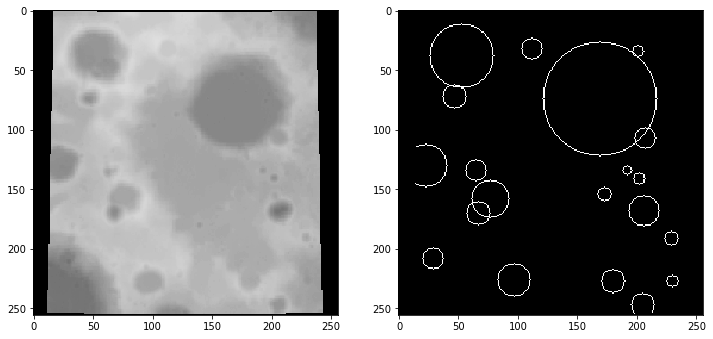

In [12]:
gen_imgs = h5py.File(zenodo_path + '/test_zenodo_images.hdf5', 'r')
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(gen_imgs['input_images'][0][...], origin='upper', cmap='Greys_r', vmin=50, vmax=200)
ax2.imshow(gen_imgs['target_masks'][0][...], origin='upper', cmap='Greys_r')
plt.show()

Arguments to `GenDataset` are listed in its docstring.  To easily run `GenDataset` and keep track of your input arguments, see the `run_input_data_gen.py` script in the repo.  This also uses `LunarLROLrocKaguya_118mperpix.png` (or any other DEM or global map); you'll have to specify its location.

# Trained Model Weights

`model_keras1.2.2.h5` and `model_keras2.h5` are respectively the Keras 1.2.2 and 2.0+ compatible model weights for the trained DeepMoon CNN.  These can be loaded into memory using Keras's `load_model` module.

**Note:** DeepMoon was train using a 16GB Tesla P100 GPU, and so the model may use prohibitive amounts of memory on systems with less GPU or system RAM.

In [13]:
from keras.models import load_model

# Use the commented out line for Keras 2.0+
#model = load_model(zenodo_path + '/model_keras2.h5')
model = load_model(zenodo_path + '/model_keras1.2.2.h5')

Using TensorFlow backend.


The model can then be used to predict target masks from input images.  Let's try inserting image 18 from the training data, and then plotting the prediction against the ground truth target mask.

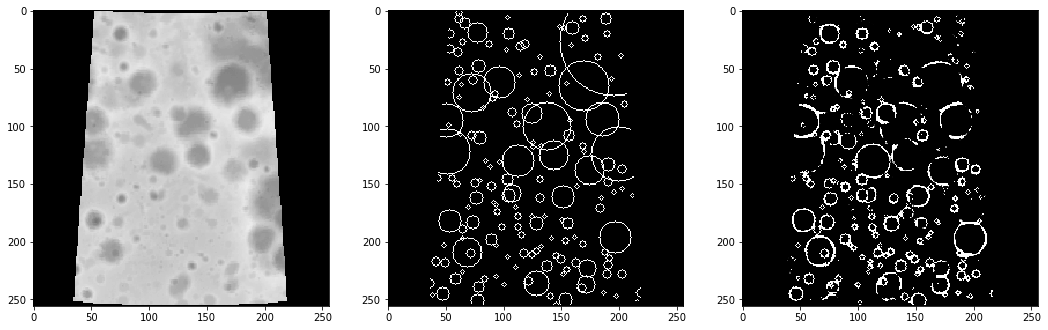

In [14]:
pred = model.predict(np.array(train_imgs['input_images'][17:18][..., np.newaxis]))

fig = plt.figure(figsize=[18, 6])
[ax1, ax2, ax3] = fig.subplots(1,3)
ax1.imshow(train_imgs['input_images'][17][...], origin='upper', cmap='Greys_r', vmin=50, vmax=200)
ax2.imshow(train_imgs['target_masks'][17][...], origin='upper', cmap='Greys_r')
ax3.imshow(pred[0], origin='upper', cmap='Greys_r')
plt.show()

As noted from the paper, the trained convnet effectively finds craters with radii $r < 15$ pixels, but has trouble with larger ones.

# Post-Processed Craters